# Import libraries

In [4]:
import os
import glob
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.optimizers import Adam
from keras import models
from sklearn.metrics import *

from DataGenerator import *
from model import *

random.seed(10)

Using TensorFlow backend.
C:\Users\JW\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [5]:
# Define the default path 
path = "D:/carvana-image-masking-challenge/"
os.chdir(path)

# Set image size
img_sz = 512

# Preview an example

Original image size is  (1918, 1280)
Original mask size is  (1918, 1280)
Reduced image size is  (512, 512)
Reduced mask size is  (512, 512)


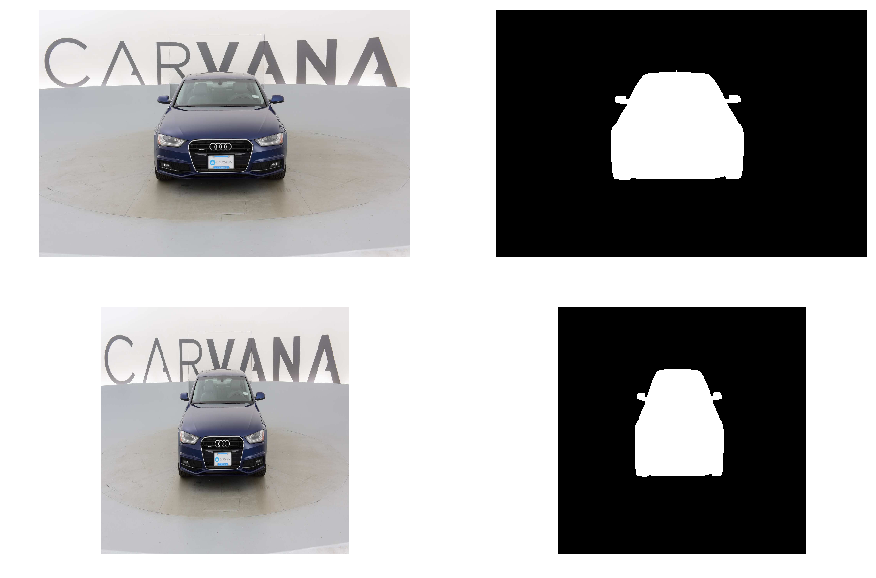

In [5]:
fig1 = plt.figure(figsize=(15,10))
# Plot an image
fig1.add_subplot(2, 2, 1)
Im1 = Image.open('train/0cdf5b5d0ce1_01.jpg')
plt.imshow(Im1)
plt.axis('off')
# Plot its mask
fig1.add_subplot(2, 2, 2)
Im1_msk = Image.open('train_masks/0cdf5b5d0ce1_01_mask.gif')
plt.imshow(Im1_msk)
plt.axis('off')
# Plot the resized image
print('Original image size is ', Im1.size)
print('Original mask size is ', Im1_msk.size)
# Plot the resized mask
fig1.add_subplot(2, 2, 3)
Im1 = Image.open('train/0cdf5b5d0ce1_01.jpg').resize((img_sz, img_sz))
plt.imshow(Im1)
plt.axis('off')

fig1.add_subplot(2, 2, 4)
Im1_msk = Image.open('train_masks/0cdf5b5d0ce1_01_mask.gif').resize((img_sz, img_sz))
plt.imshow(Im1_msk)
plt.axis('off')

print('Reduced image size is ', Im1.size)
print('Reduced mask size is ', Im1_msk.size)

# Preview a group of 16 images

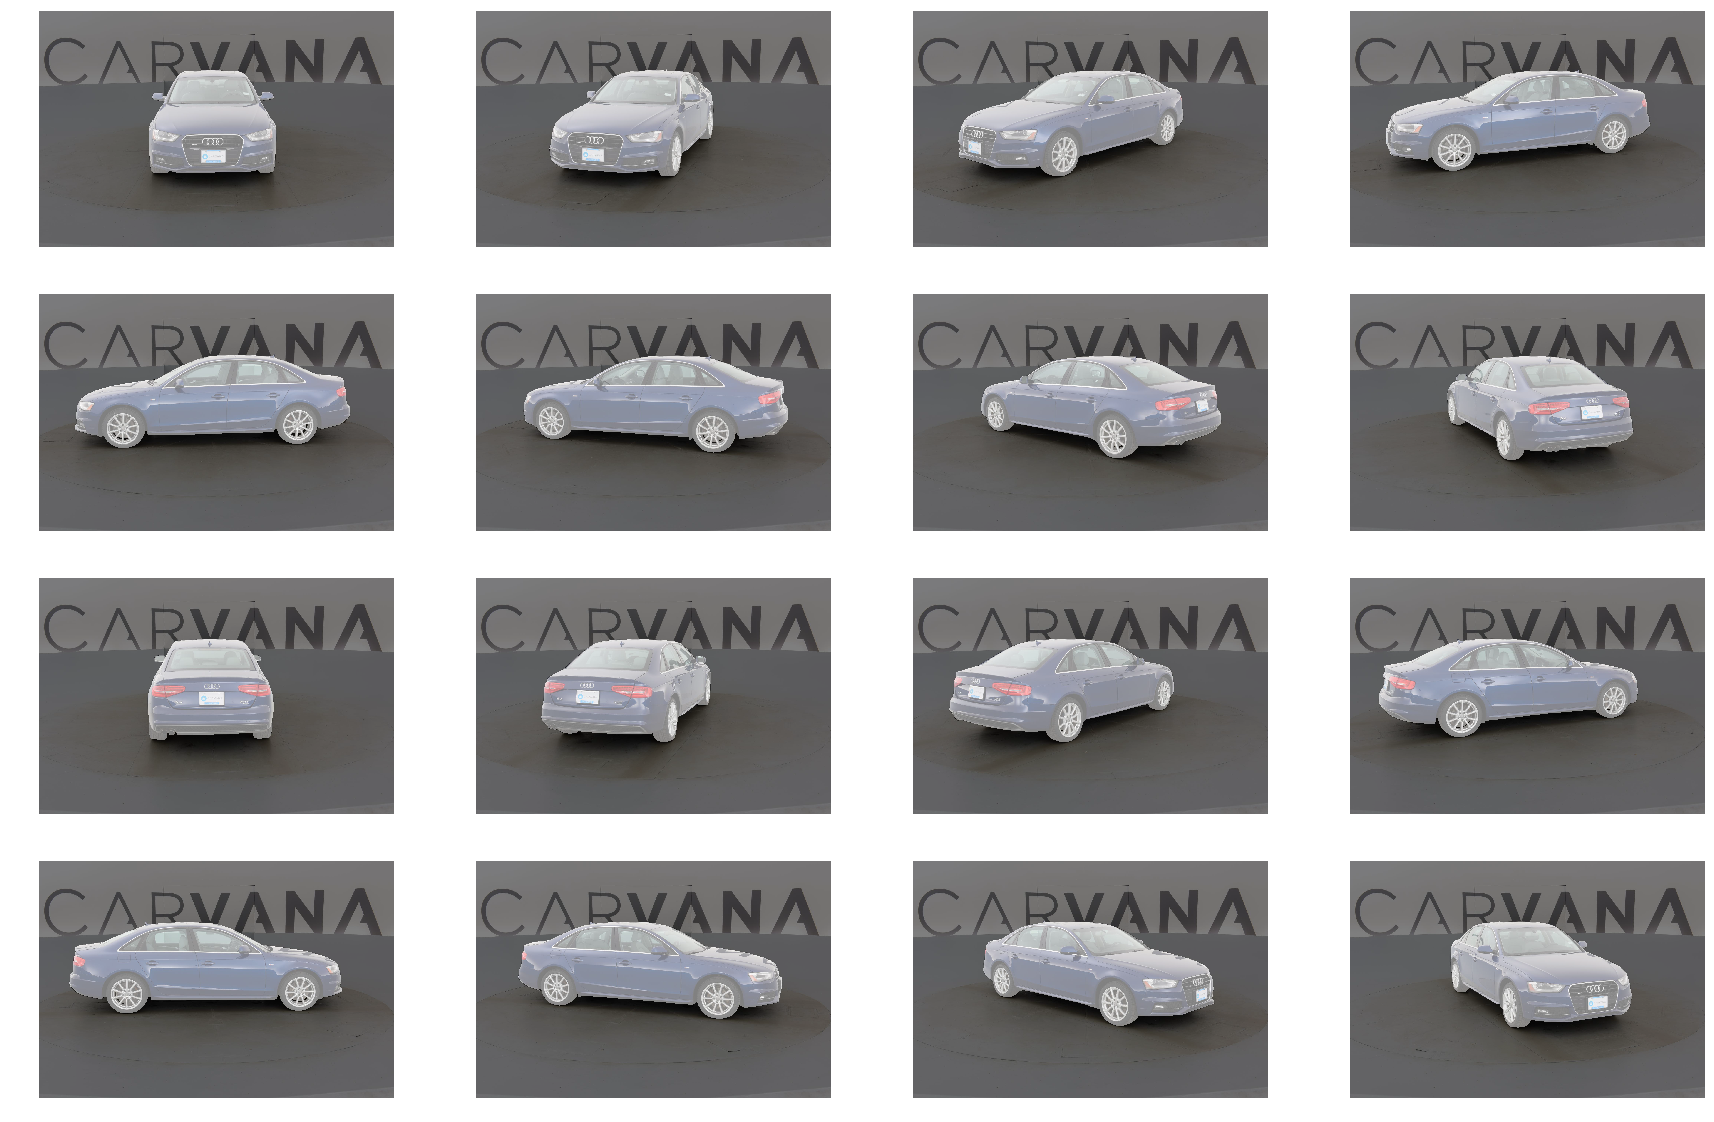

In [6]:
fig2 = plt.figure(figsize=(30,20))

for i in range(16):
    fig2.add_subplot(4, 4, i+1)
    if i < 9:
        Im2 = Image.open('train/0cdf5b5d0ce1_0' + str(i+1) + '.jpg')
        plt.imshow(Im2)
        Im2_msk = Image.open('train_masks/0cdf5b5d0ce1_0' + str(i+1) + '_mask.gif')
        plt.imshow(Im2_msk , alpha=0.5)
        plt.axis('off')
    else:
        Im2 = Image.open('train/0cdf5b5d0ce1_' + str(i+1) + '.jpg')
        plt.imshow(Im2)
        Im2_msk = Image.open('train_masks/0cdf5b5d0ce1_' + str(i+1) + '_mask.gif')
        plt.imshow(Im2_msk , alpha=0.5)
        plt.axis('off')

# Visualize the meta data

In [7]:
## Check metadata
df = pd.read_csv('metadata.csv')
print(df.count())
df = df.dropna()
df.head()

id       6572
year     6561
make     6561
model    6561
trim1    6510
trim2    6495
dtype: int64


,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


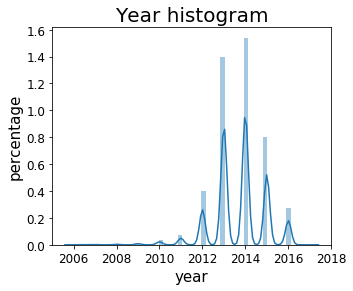

In [8]:
# Plot the histogram of the year column
fig = plt.figure(figsize=(5,4))
sns.distplot(df.year).set_title('Year histogram')
plt.title('Year histogram', fontsize=20)
plt.xlabel('year',fontsize=15)
plt.ylabel('percentage',fontsize=15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)

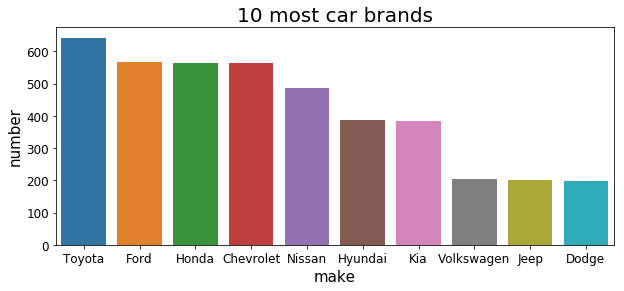

In [9]:
# Plot the 10 most makes
df_make = df.groupby(['make']).size()
df_make_10 = df_make.sort_values(ascending=False)[:10]
fig = plt.figure(figsize=(10,4))
sns.barplot(x=df_make_10.index, y=df_make_10.values)
plt.title('10 most car brands', fontsize=20)
plt.xlabel('make',fontsize=15)
plt.ylabel('number',fontsize=15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Save smaller image files to disk

In [11]:
for Im_name, msk_name in zip(glob.glob('train/*.jpg'),glob.glob('train_masks/*.gif')):
    Im = Image.open(Im_name).resize((img_sz,img_sz))
    msk = Image.open(msk_name).resize((img_sz,img_sz))
    Im.save('preprocessed/' + Im_name, 'JPEG')
    msk.save('preprocessed/' + msk_name, 'GIF')

# Train/val/test splitting
All car images, as well as their masks, are allocated into three pools: train, validation and test. Here is the method.

(1) First, loop through all image file names and generate a list with unique car names (Im_names) and unique car numbers (Im_idxs), while preserving the order.

(2) Randomly shuffle the list.

(3) Split the list into three sublists, namely, Im_trains, Im_val and Im_test.

(4) Combine Im_idxs with Im_trains, Im_val and Im_test to reconstruct the full image names.

(5) Create a dictionary to store tran/val/test lists, defining the keys to retrieve them.



In [6]:
Im_names = []
Im_idxs = []

for Im_name in glob.glob('train/*.jpg'):
    Im_name = Im_name.split('\\')[1]
    Im_name, Im_idx = Im_name.split('_')
    if Im_name not in Im_names:
        Im_names.append(Im_name)
    if Im_idx not in Im_idxs:
        Im_idxs.append(Im_idx)

In [7]:
print(Im_names[:5])
random.Random(4).shuffle(Im_names) # Randomly shuffle the Im_names before feeding to the data generator
print(Im_names[:5])

['00087a6bd4dc', '02159e548029', '03a857ce842d', '0495dcf27283', '04bd942b463b']
['be86e79f1225', 'a078586ccdee', 'a4551c5409e3', '11f3dc041cfb', '48b3f0c936b5']


In [8]:
split_ratio = [0.6, 0.2, 0.2] # Define a train/val/test ratio

Im_train = Im_names[:int(split_ratio[0] * len(Im_names))]
Im_val = Im_names[int(split_ratio[0] * len(Im_names)):]
Im_val, Im_test = Im_val[:int(len(Im_val)/2)], Im_val[int(len(Im_val)/2):]

Im_trains = []
Im_vals = []
Im_tests = []

_ = [Im_trains.append(Im_name + '_' + Im_idx) for Im_name in Im_train for Im_idx in Im_idxs]
_ = [Im_vals.append(Im_name + '_' + Im_idx) for Im_name in Im_val for Im_idx in Im_idxs]
_ = [Im_tests.append(Im_name + '_' + Im_idx) for Im_name in Im_test for Im_idx in Im_idxs]

dic_Im_names = {'train': Im_trains,
                'val': Im_vals,
                'test': Im_tests}

# Create keras train/val/test generator objects

In [9]:
# Create DataGenrator by calling DataGenerator in DataGenerator.py
train_generator = DataGenerator(dic_Im_names=dic_Im_names, aug_on=False)
val_generator = DataGenerator(dic_Im_names=dic_Im_names, datatype='val')
test_generator = DataGenerator(dic_Im_names=dic_Im_names, datatype='test', shuffle=False)

# Load unet model

In [122]:
# Create model by calling unet in model.py
model = unet()
# model.summary()

C:\Users\JW\Anaconda3\lib\model.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [123]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
# Uncomment the next line to train a model.
# history = model.fit_generator(generator=train_generator,validation_data=val_generator, epochs=200)

# Load weights from saved model.
model.load_weights('MODEL/512/Unet_model_with_datagenerator5.h5')

# Visualize training history

C:\Users\JW\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\JW\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


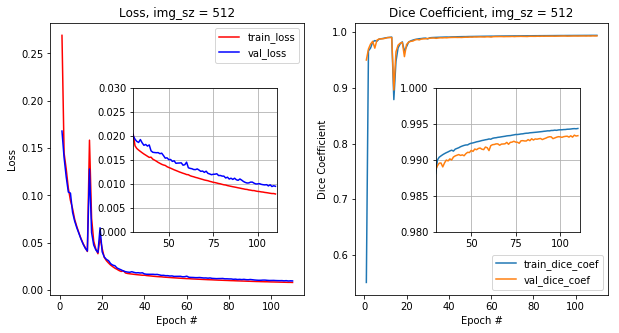

In [34]:
# History stores the loss and dice_coef of each epoch, where
# arr_0: train loss
# arr_1: val loss
# arr_2: train dice_coef
# arr_3: val dice_coef
history = np.load('model/512/history.npz')

model_coef_fig = plt.figure(figsize=(10,5))
model_coef_fig.add_subplot(1, 2, 1)
plt.title('Loss, img_sz = 512')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(np.arange(1, 111, 1), history['arr_0'], label='train_loss', color='r')
plt.plot(np.arange(1, 111, 1), history['arr_1'], label='val_loss', color='b')
plt.legend(loc=1)

model_coef_fig.add_subplot(1, 2, 1)
innerplot1 = plt.axes([.24, .3, .2, .4])
plt.plot(np.arange(1, 111, 1), history['arr_0'], color='r')
plt.plot(np.arange(1, 111, 1), history['arr_1'], color='b')
innerplot1.set_xlim([30,111])
innerplot1.set_ylim([0,0.03])
plt.grid()


model_coef_fig.add_subplot(1, 2, 2)
plt.title('Dice Coefficient, img_sz = 512')
plt.xlabel('Epoch #')
plt.ylabel('Dice Coefficient')
plt.plot(np.arange(1, 111, 1), history['arr_2'], label='train_dice_coef')
plt.plot(np.arange(1, 111, 1), history['arr_3'], label='val_dice_coef')
plt.legend(loc=4)

model_coef_fig.add_subplot(1, 2, 2)
innerplot2 = plt.axes([.66, .3, .2, .4])
plt.plot(np.arange(1, 111, 1), history['arr_2'])
plt.plot(np.arange(1, 111, 1), history['arr_3'])
innerplot2.set_xlim([30,111])
innerplot2.set_ylim([0.98,1])
plt.grid()

# Evaluate model on test set

In [199]:
score = model.evaluate_generator(test_generator)
print ("Test loss = ", score[0])
print ("Test dice_coef = ", score[1])

Test loss =  0.00861717731459
Test dice_coef =  0.994036121294


# Make predictions for each image in Im_tests

In [16]:
# Define a same dice_coef funtion taking numpy arrays as inputs.
def dice_coef_np(y_true, pred):
    
    y_true = np.round(np.ndarray.flatten(y_true))
    y_pred = np.squeeze(pred, axis=0)
    y_pred = np.round(np.ndarray.flatten(y_pred))
    
    intersection = sum(y_true * y_pred)
    
    return 2 * intersection / (sum(y_true) + sum(y_pred))

In [19]:
test_scores = []
X_test = []
y_test = []
# Loop through all the testing images and calculate the dice_coef.
for Im_name in Im_tests:
    # Note that the folder name is 'train' but it contains the full list of images including train/val/test.
    # We simply "pick up" test images by matching the image names in the Im_tests list.
    X_test = np.array(Image.open('preprocessed/train/' + Im_name))/255.0
    X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1], X_test.shape[2])
    y_test = np.array(Image.open('preprocessed/train_masks/' + Im_name.split('.')[0] + '_mask.gif'))
    pred = model.predict(X_test)
    test_scores.append(dice_coef_np(y_test, pred))

In [82]:
np.save('model/test_scores', test_scores)
scores = test_scores.copy()

In [86]:
# Create a DataFrame containing the test image names and their corresponding scores (dice_coef)
df_score = pd.DataFrame({'Im_names_test': Im_tests,
                         'scores': scores})
df_score.head()

,Im_names_test,scores
0,eaf9eb0b2293_01.jpg,0.987085
1,eaf9eb0b2293_02.jpg,0.995681
2,eaf9eb0b2293_03.jpg,0.995675
3,eaf9eb0b2293_04.jpg,0.990478
4,eaf9eb0b2293_05.jpg,0.995210


# Visualize good predictions

In [93]:
# Visualize first 5 largest scores
# Sort df_score by the score vaules with ascending=False.
df_score.sort_values(by=['scores'], ascending=False, inplace=True)
# sns.barplot(y=df_score.iloc[:10].Im_names_test,
#             x=df_score.iloc[:10].scores)
print('5 best predictions')
df_score.head()

5 best predictions


,Im_names_test,scores
113,2267f4aa0d2c_02.jpg,0.997615
114,2267f4aa0d2c_03.jpg,0.997280
502,9ab2a45de8c7_07.jpg,0.997027
127,2267f4aa0d2c_16.jpg,0.996976
126,2267f4aa0d2c_15.jpg,0.996976


In [113]:
Im_good = Image.open('preprocessed/train/2267f4aa0d2c_02.jpg')
msk_good = Image.open('preprocessed/train_masks/2267f4aa0d2c_02_mask.gif')

X = np.array(Im_good)/255.0
pred_good = model.predict(X.reshape(1, X.shape[0], X.shape[1], X.shape[2]))
pred_good = np.squeeze(pred_good, axis=[0,3])

(-0.5, 511.5, 511.5, -0.5)

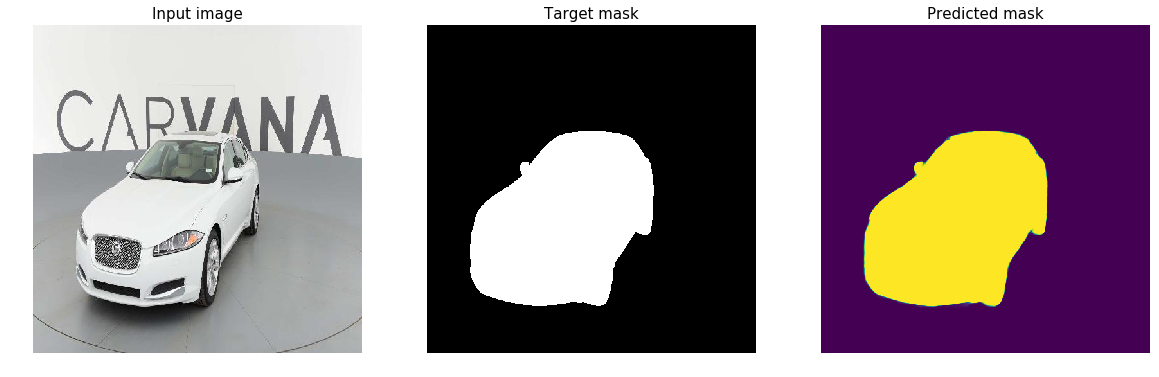

In [114]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(Im_good)
plt.title('Input image', fontsize=15)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(msk_good)
plt.title('Target mask', fontsize=15)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(pred_good)
plt.title('Predicted mask', fontsize=15)
plt.axis('off')

# Visualize bad predictions

In [115]:
# Visualize first 5 smallest scores
# Sort df_score by the score vaules with ascending=True.
df_score.sort_values(by=['scores'], ascending=True, inplace=True)
print('5 worst predictions')
df_score.head()

5 worst predictions


,Im_names_test,scores
104,1390696b70b6_09.jpg,0.982636
256,ae296a20fdd9_01.jpg,0.983955
103,1390696b70b6_08.jpg,0.984998
471,61060ada97c9_08.jpg,0.985197
920,28109f18d9d4_09.jpg,0.985368


In [116]:
Im_bad = Image.open('preprocessed/train/1390696b70b6_09.jpg')
msk_bad = Image.open('preprocessed/train_masks/1390696b70b6_09_mask.gif')

X = np.array(Im_bad)/255.0
pred_bad = model.predict(X.reshape(1, X.shape[0], X.shape[1], X.shape[2]))
pred_bad = np.squeeze(pred_bad, axis=[0,3])

(-0.5, 511.5, 511.5, -0.5)

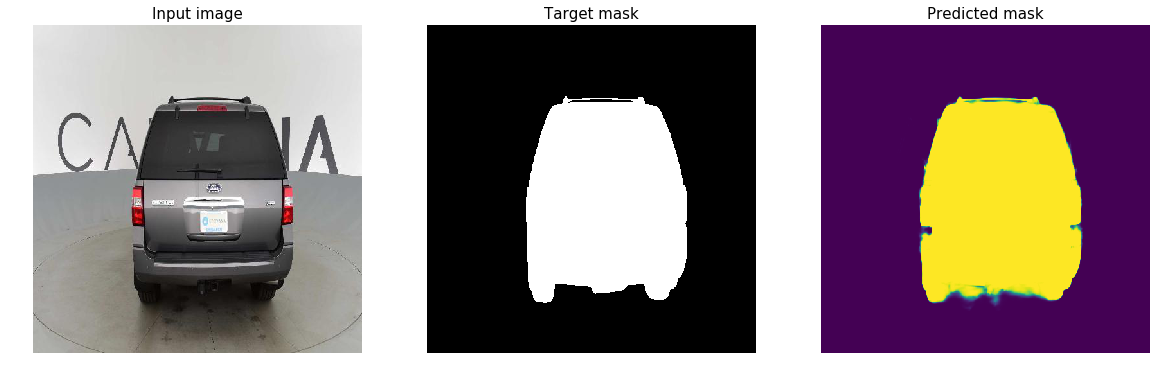

In [117]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(Im_bad)
plt.title('Input image', fontsize=15)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(msk_bad)
plt.title('Target mask', fontsize=15)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(pred_bad)
plt.title('Predicted mask', fontsize=15)
plt.axis('off')

# Visualize the feature map

In [137]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
nn_layer_num = len(layer_outputs)

In [139]:
# Retrieve a test image from test generator
test_im = test_generator.__getitem__(0)[0][0]
test_im = test_im.reshape(1, test_im.shape[0], test_im.shape[1], test_im.shape[2])
# Returns a list of 39 Numpy arrays: one array per layer activation
activations = activation_model.predict(test_im)
print(len(activations))

39


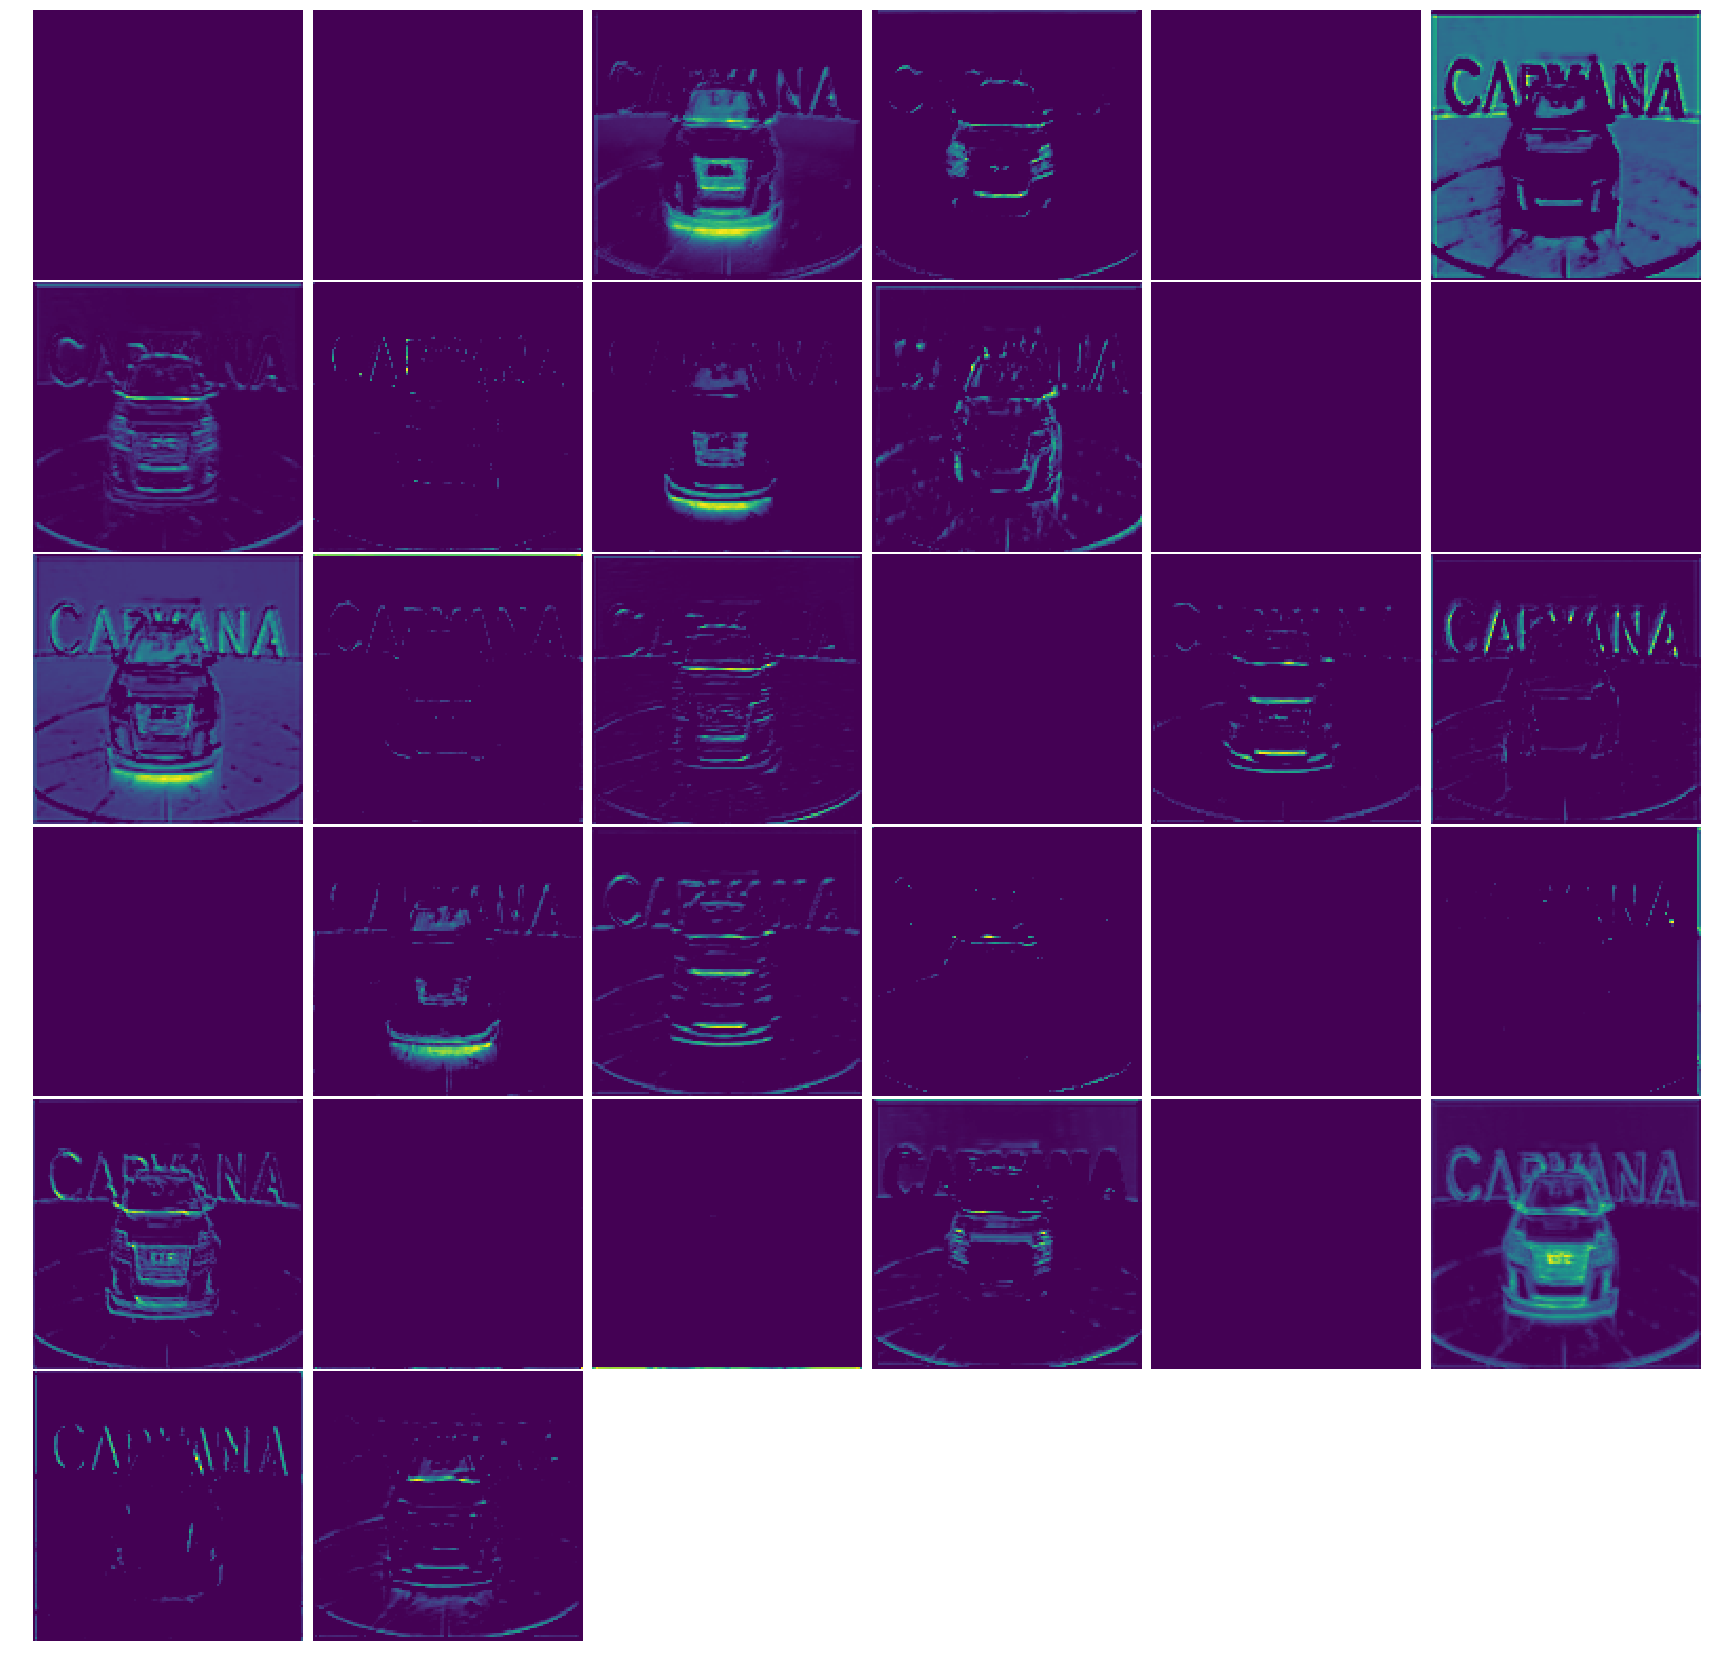

In [198]:
fig2 = plt.figure(figsize=(30,30))
layer_activation = activations[8] # Change i in activations[i] to visualize feature maps of different layers
filter_num = layer_activation.shape[-1]
for i in range(filter_num):
    plot_sz = np.ceil(np.sqrt(filter_num))
    plt.subplot(plot_sz, plot_sz, i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.axis('off')